## Akraradet-like Lab06 

In [1]:
!wget https://raw.githubusercontent.com/pytorch/vision/master/references/detection/utils.py
!wget https://raw.githubusercontent.com/pytorch/vision/master/references/detection/coco_utils.py
!wget https://raw.githubusercontent.com/pytorch/vision/master/references/detection/transforms.py
!wget https://raw.githubusercontent.com/pytorch/vision/master/references/detection/engine.py
!wget https://raw.githubusercontent.com/pytorch/vision/master/references/detection/coco_eval.py

--2021-03-04 08:55:27--  https://raw.githubusercontent.com/pytorch/vision/master/references/detection/utils.py
Connecting to 192.41.170.23:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 9757 (9.5K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]   9.53K  --.-KB/s    in 0s      

2021-03-04 08:55:28 (24.5 MB/s) - ‘utils.py’ saved [9757/9757]

--2021-03-04 08:55:29--  https://raw.githubusercontent.com/pytorch/vision/master/references/detection/coco_utils.py
Connecting to 192.41.170.23:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 8808 (8.6K) [text/plain]
Saving to: ‘coco_utils.py’

coco_utils.py       100%[===================>]   8.60K  --.-KB/s    in 0.001s  

2021-03-04 08:55:30 (14.4 MB/s) - ‘coco_utils.py’ saved [8808/8808]

--2021-03-04 08:55:30--  https://raw.githubusercontent.com/pytorch/vision/master/references/detection/transforms.py
Connecting to 192.41.170.23:3128... connected.
Proxy re

In [2]:
# !pip3 install pycocotools
# !pip3 install scikit-build
# !pip3 install cmake
# !pip3 install opencv-python

In [3]:
#!wget https://raw.githubusercontent.com/akraradets/2021JanRTML/3cd71bba5b88d5fa5d1137e660b7bd7d778b83d4/lab6/coco_utils.py

--2021-03-04 09:01:29--  https://raw.githubusercontent.com/akraradets/2021JanRTML/3cd71bba5b88d5fa5d1137e660b7bd7d778b83d4/lab6/coco_utils.py
Connecting to 192.41.170.23:3128... connected.
Proxy request sent, awaiting response... 200 OK
Length: 10211 (10.0K) [text/plain]
Saving to: ‘coco_utils.py.1’

coco_utils.py.1     100%[===================>]   9.97K  --.-KB/s    in 0s      

2021-03-04 09:01:29 (20.5 MB/s) - ‘coco_utils.py.1’ saved [10211/10211]



In [3]:
#!ln -s ~/Cityscapes/ ./Cityscapes

In [15]:
import torch
import torchvision
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.datasets import CocoDetection

import utils
from coco_utils_city import get_city
import transforms

# Load a model pre-trained on COCO and put it in inference mode

print('Loading pretrained model...')
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval()

# city_path = "root/Cityscapes" <<< no need to do this because its already given in the get_city

preprocess = transforms.Compose([
    transforms.ToTensor()
])
# print('Loading COCO train, val datasets...')
city_val_dataset = get_city(preprocess)
# coco_val_dataset = get_coco(coco_path, 'val', transform)

def collate_fn(batch):
    return tuple(zip(*batch))

val_dataloader = torch.utils.data.DataLoader(city_val_dataset, batch_size=1, shuffle=False, num_workers=0, collate_fn=collate_fn)

Loading pretrained model...
loading annotations into memory...
Done (t=7.52s)
creating index...
index created!


In [16]:
from chosen_gpu import get_freer_gpu
device = torch.device(get_freer_gpu()) if torch.cuda.is_available() else torch.device("cpu")
print("Configured device: ", device)

Configured device:  cuda:3


In [17]:
#put model to device
model.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample): 

In [18]:
images, targets = next(iter(val_dataloader))

images = [img.to(device) for img in images]
print(len(images))

predictions = model(images)

print('Prediction keys:', list(dict(predictions[0])))
print('Boxes shape:', predictions[0]['boxes'].shape)
print('Labels shape:', predictions[0]['labels'].shape)
print('Scores shape:', predictions[0]['scores'].shape)
print('Masks shape:', predictions[0]['masks'].shape)

1
Prediction keys: ['boxes', 'labels', 'scores', 'masks']
Boxes shape: torch.Size([58, 4])
Labels shape: torch.Size([58])
Scores shape: torch.Size([58])
Masks shape: torch.Size([58, 1, 1024, 2048])


In [19]:

import numpy as np
import cv2
import random

# Array of labels for COCO dataset (91 elements)

coco_names = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

# Random colors to use for labeling objects

COLORS = np.random.uniform(0, 255, size=(len(coco_names), 3)).astype(np.uint8)

# Overlay masks, bounding boxes, and labels on input numpy image

def draw_segmentation_map(image, masks, boxes, labels):
    alpha = 1
    beta = 0.5 # transparency for the segmentation map
    gamma = 0 # scalar added to each sum
    # convert from RGB to OpenCV BGR format
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    '''
    When the image file is read with the OpenCV function imread(), 
    the order of colors is BGR (blue, green, red). 
    On the other hand, in Pillow, 
    the order of colors is assumed to be RGB (red, green, blue).
    Therefore, if you want to use both the Pillow function and the OpenCV function, 
    you need to convert BGR and RGB.
    Soooo we use PIL RGB in the begining so to use cv2 we must convert it to BGR!!!
    '''
    for i in range(len(masks)):
        mask = masks[i,:,:]
        red_map = np.zeros_like(mask).astype(np.uint8) #"u" are unsigned 
        green_map = np.zeros_like(mask).astype(np.uint8)
        blue_map = np.zeros_like(mask).astype(np.uint8)
        # apply a randon color mask to each object
        color = COLORS[random.randrange(0, len(COLORS))]
        red_map[mask > 0.5] = color[0]
        green_map[mask > 0.5] = color[1]
        blue_map[mask > 0.5] = color[2]
        # combine all the masks into a single image
        segmentation_map = np.stack([red_map, green_map, blue_map], axis=2) 
        # RGB channel = 3 channels so for segmentation you gotta use 3 channels too (use random colours)
        # apply colored mask to the image
        image = cv2.addWeighted(image, alpha, segmentation_map, beta, gamma)
        # draw the bounding box around each object
        p1 = (int(boxes[i][0]), int(boxes[i][1]))
        p2 = (int(boxes[i][2]), int(boxes[i][3]))
        color = (int(color[0]), int(color[1]), int(color[2]))
        cv2.rectangle(image, p1, p2, color, 2)
        # put the label text above the objects
        p = (int(boxes[i][0]), int(boxes[i][1]-10))
        cv2.putText(image, labels[i], p, cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2, cv2.LINE_AA)
    
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Overlay masks, bounding boxes and labels of objects with scores greater than
# threshold on one of the images in the input tensor using the predictions output by mask R-CNN

def prediction_to_mask_image(images, predictions, img_index, threshold):
    scores = predictions[img_index]['scores']
    boxes_to_use = scores >= threshold
    img = (images[img_index].cpu().permute(1, 2, 0).numpy() * 255).astype(np.uint8) # WHY?????????? 
    masks = predictions[img_index]['masks'][boxes_to_use, :, :].cpu().detach().squeeze(1).numpy() #[boxes_to_use, :, :] masks 3 channels
    boxes = predictions[img_index]['boxes'][boxes_to_use, :].cpu().detach().numpy() #[boxes_to_use, :] 2 positions
    labels = predictions[img_index]['labels'][boxes_to_use].cpu().numpy() #[boxes_to_use] 1 thing
    labels = [ coco_names[l] for l in labels ]

    return draw_segmentation_map(img, masks, boxes, labels)

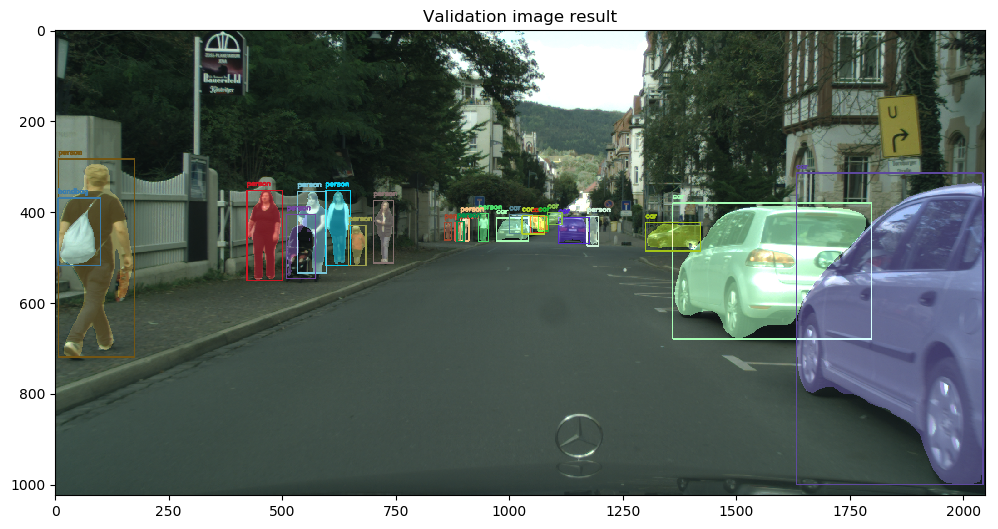

In [20]:
from matplotlib import pyplot as plt

masked_img = prediction_to_mask_image(images, predictions, 0, 0.5)
plt.figure(1, figsize=(12, 9), dpi=100)
plt.imshow(masked_img)
plt.title('Validation image result')
plt.show()

In [21]:
from engine import evaluate

results = evaluate(model, val_dataloader, device)

Test:  [   0/2975]  eta: 4:49:59  model_time: 0.5558 (0.5558)  evaluator_time: 0.8258 (0.8258)  time: 5.8485  data: 0.4718  max mem: 0
Test:  [ 100/2975]  eta: 1:06:59  model_time: 0.3555 (0.4239)  evaluator_time: 0.3746 (0.4730)  time: 1.2912  data: 0.4369  max mem: 0
Test:  [ 200/2975]  eta: 1:06:29  model_time: 0.4574 (0.4293)  evaluator_time: 0.5146 (0.4833)  time: 1.6548  data: 0.5834  max mem: 0
Test:  [ 300/2975]  eta: 1:07:12  model_time: 0.4314 (0.4346)  evaluator_time: 0.4883 (0.4909)  time: 1.6716  data: 0.6933  max mem: 0
Test:  [ 400/2975]  eta: 1:04:04  model_time: 0.4421 (0.4209)  evaluator_time: 0.4969 (0.4712)  time: 1.6390  data: 0.7157  max mem: 0
Test:  [ 500/2975]  eta: 1:02:27  model_time: 0.4325 (0.4227)  evaluator_time: 0.4958 (0.4738)  time: 1.6718  data: 0.6749  max mem: 0
Test:  [ 600/2975]  eta: 1:01:31  model_time: 0.4487 (0.4348)  evaluator_time: 0.4869 (0.4877)  time: 1.7160  data: 0.6544  max mem: 0
Test:  [ 700/2975]  eta: 1:00:26  model_time: 0.4117 (0

In [1]:
results = open("output_city.txt", "r")
print(results.read())

Test:  [   0/2975]  eta: 4:49:59  model_time: 0.5558 (0.5558)  evaluator_time: 0.8258 (0.8258)  time: 5.8485  data: 0.4718  max mem: 0
Test:  [ 100/2975]  eta: 1:06:59  model_time: 0.3555 (0.4239)  evaluator_time: 0.3746 (0.4730)  time: 1.2912  data: 0.4369  max mem: 0
Test:  [ 200/2975]  eta: 1:06:29  model_time: 0.4574 (0.4293)  evaluator_time: 0.5146 (0.4833)  time: 1.6548  data: 0.5834  max mem: 0
Test:  [ 300/2975]  eta: 1:07:12  model_time: 0.4314 (0.4346)  evaluator_time: 0.4883 (0.4909)  time: 1.6716  data: 0.6933  max mem: 0
Test:  [ 400/2975]  eta: 1:04:04  model_time: 0.4421 (0.4209)  evaluator_time: 0.4969 (0.4712)  time: 1.6390  data: 0.7157  max mem: 0
Test:  [ 500/2975]  eta: 1:02:27  model_time: 0.4325 (0.4227)  evaluator_time: 0.4958 (0.4738)  time: 1.6718  data: 0.6749  max mem: 0
Test:  [ 600/2975]  eta: 1:01:31  model_time: 0.4487 (0.4348)  evaluator_time: 0.4869 (0.4877)  time: 1.7160  data: 0.6544  max mem: 0
Test:  [ 700/2975]  eta: 1:00:26  model_time: 0.4117 (0